In [102]:
from diffractio import degrees, mm, plt, um
from diffractio.scalar_sources_X import Scalar_source_X
from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.utils_optics import field_parameters
from diffractio.utils_drawing import draw_several_fields
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time, datetime

template = "plotly_white"
from matplotlib import rcParams

rcParams["figure.dpi"] = 75

# change matplotlib template to light
plt.style.use("default")


def time_now():
    return datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")


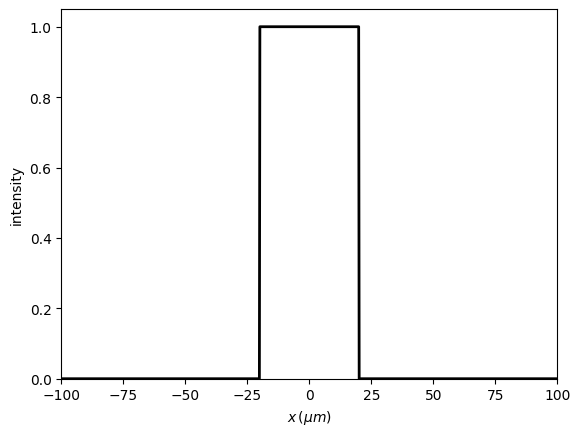

In [91]:
slit_width = 40
field_x = 200
x = field_x // 2
x_spacing = 1000
x0 = np.linspace(-x * um, x * um, x_spacing)
wavelength = 0.6238 * um

# plane wave
u0 = Scalar_source_X(x=x0, wavelength=wavelength)
u0.plane_wave(A=1, theta=0)

# slit
t0 = Scalar_mask_X(x=x0, wavelength=wavelength)
t0.slit(x0=0, size=slit_width * um)
# t0.two_levels(level1=0, level2=2)
t0.draw("intensity")

u1 = u0 * t0


In [ ]:
AMPLIFICATION = 1
# Propagation a certain distance and draw
for z in [10, 25, 100, 250, 500, 1_000, 10_000]:
    u = u1.RS(
        z=z * um, new_field=True, verbose=True, amplification=AMPLIFICATION
    )
    u.draw(kind="intensity")


In [103]:
z_distance = []
threshold = 500
close_step = 1
far_step = 1
for z in range(1, threshold + close_step, close_step):
    u_ = u1.RS(z=z * um, new_field=True, verbose=False)
    amplitude, intensity, phase = field_parameters(u_.u)
    z_distance.append(
        np.column_stack((np.ones_like(u_.x) * z, u_.x, intensity))
    )
for z in range(threshold, 3000 + far_step + 1, far_step):
    u_ = u1.RS(z=z * um, new_field=True, verbose=False)
    amplitude, intensity, phase = field_parameters(u_.u)
    z_distance.append(
        np.column_stack((np.ones_like(u_.x) * z, u_.x, intensity))
    )
grid = pd.DataFrame(np.vstack(z_distance)).rename(
    columns={0: "z", 1: "x", 2: "y"}
)


In [104]:
# Experimenting with rounding values in X
grid["x"] = grid.x.round(0)
y_np = pd.pivot_table(grid, values="y", index="z", columns="x")
y_np = y_np.div(y_np.max().max())

fig = go.Figure(
    data=[
        go.Surface(
            x=y_np.columns.values,
            z=y_np.values,
            y=y_np.index.values,
            showscale=False,
            hoverinfo=None,
            name="1slit",
            lighting=dict(
                diffuse=0.0, specular=0.0, fresnel=0.0, roughness=0.0
            ),
            # colorscale=["red", "black"],
            colorscale="Turbo",
            reversescale=True,
            contours_z=dict(
                project_x=False,
                project_y=False,
                project_z=False,
                highlight=True,
                highlightcolor="red",
                highlightwidth=1,
            ),
            contours_y=dict(
                highlightcolor="red",
                project_y=True,
                project_z=False,
                project_x=False,
                highlight=True,
                width=1,
                highlightwidth=1,
                show=False,
            ),
            contours_x=dict(
                highlightcolor="red",
                project_x=True,
                project_y=False,
                project_z=False,
                highlight=False,
                width=16,
                show=False,
                highlightwidth=1,
            ),
        )
    ],
)
fig.update_layout(template=template)
fig.update_layout(
    scene=dict(
        xaxis_showspikes=False,
        yaxis_showspikes=False,
        zaxis_showspikes=False,
        xaxis_visible=False,
        yaxis_visible=False,
        zaxis_visible=False,
        yaxis_range=[
            y_np.index.to_numpy().min(),
            y_np.index.to_numpy().max() * 1.5,
        ],
    ),
    margin=dict(t=0, b=0, l=0, r=0),
)
# keep 3d aspect ratio
fig.update_layout(scene_aspectmode="manual")
fig.update_layout(scene_aspectratio=dict(x=1, y=4, z=1))
fig.write_html(f"plotly_graphs/diffractio/slit_3D_research.html")
fig.write_html(f"plotly_graphs/diffractio/slit_3D_{time_now()}.html")
# fig.show()

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x=y_np.columns.values,
        z=y_np.values,
        y=y_np.index.values,
        reversescale=True,
        colorscale="Turbo",
    )
)
fig.update_layout(template=template)
# keep aspect ratio
fig.update_xaxes(scaleanchor="y", scaleratio=10)

fig.update_layout(
    margin=dict(t=50, b=0, l=0, r=0),
)
fig.write_html(f"plotly_graphs/diffractio/slit_heatmap_research.html")
fig.write_html(f"plotly_graphs/diffractio/slit_heatmap_{time_now()}.html")


In [35]:
fig = px.line(
    grid,
    x="x",
    y="y",
    animation_frame="z",
    animation_group="y",
    template=template,
    color_discrete_sequence=["crimson", "blue"],
)
fig.write_html(f"plotly_graphs/diffractio/timescatter_{time_now()}.html")


In [20]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=z_distance[z][:, 1],
            z=z_distance[z][:, 2],
            y=z_distance[z][:, 0],
            name="1slit",
            mode="lines",
            marker_size=1,
            marker_color="crimson",
            # opacity=0.1,
            line_width=2,
        )
        for z in range(len(z_distance))
    ],
    layout=dict(width=800, height=800),
)
# fig.for_each_trace(
#     lambda trace: trace.update(
#         colorscale=["black", "red"],
#         reversescale=False,
#         contours_z=dict(usecolormap=False, project_z=False),
#         contours_y=dict(highlightcolor="red", project_y=True),
#     )
#     if trace.name == "1slit"
#     else (),
# )
fig.update_layout(template=template)
fig.update_layout(
    scene=dict(
        xaxis_showspikes=False,
        yaxis_showspikes=False,
        zaxis_showspikes=False,
        xaxis_visible=False,
        yaxis_visible=False,
        zaxis_visible=False,
    ),
    margin=dict(t=0, b=0, l=0, r=0),
)
fig.write_html(f"plotly_graphs/diffractio/3d_scatter_{time_now()}.html")
# fig.show()
